In [1]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import TranscriptionDataset, collate_fn
from Model.encoder_net import EncoderNet
from Model.decoder_net import DecoderNet
from train import train_transcriber, pre_train_encoder
print(torch.__version__)
from tqdm import tqdm_notebook as tqdm


/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.4.0


In [2]:
# torch.backends.cudnn.enabled = False

### 1. We now Train the Encoder-Decoder Model
> * First we pre-train the encoder on a binary classification task. 
> * Good performance on this task is a good indicator that the encoder is modelling the distribution of the underlying data properly -- This is crucial for the correct functioning of 
our system

#### a) Pre-Trin Encoder
---

In [3]:
def pre_train_encoder_network():
    '''
    We pretrain the encoder to solve be able to classify an image as either
    Ingridients or Nutrition_Facts. An encoder that is able to do this is a good starting
    point for the transcription task.
    '''
    IMAGE_DIR = '../Data/FullData/Cropped_Images/'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    WORD_VEC_PATH = '../Data/FullData/Transcriptions/nutrition_vectors.npy'
    INDEX_TO_TERM_PATH = '../Data/FullData/Transcriptions/index_term_dict.npy'
    TERM_TO_INDEX_PATH = '../Data/FullData/Transcriptions/term_index_dict.npy'
    PATH_TO_MEAN_IMAGE = '../Data/FullData/512_512_mean.npy'
    debug = not torch.cuda.is_available()
    train_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='train'
    )
    train_loader = DataLoader( 
        train_dataset, batch_size=45, shuffle=True,
        num_workers=16, collate_fn=collate_fn
    )
    dev_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='dev',
    )
    dev_loader = DataLoader(
        dev_dataset, batch_size=45, shuffle=True, 
        num_workers=16, collate_fn=collate_fn
    )
    config = {
        'keep_prob': 0.995
    }
    learning_rate = 0.5e-3
    
    encoder = EncoderNet(config_params=config)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, encoder.parameters()), 
        lr=learning_rate, weight_decay=0.005
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, [5, 10, 20, 30, 40, 50, 100, 150], gamma=0.5
    )
    return pre_train_encoder(
        encoder, optimizer, train_loader, dev_loader, scheduler=scheduler,
        epochs=5, restore=True, save=False
    )

In [4]:
# losses, accuracies = pre_train_encoder_network()

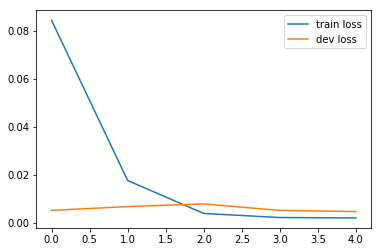

In [6]:
plt.plot(losses[0], label='train loss'); plt.plot(losses[1], label='dev loss')
plt.legend()

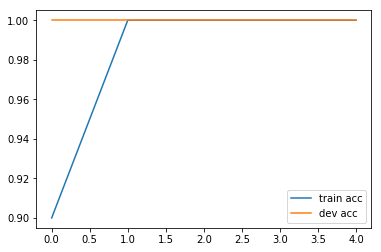

In [7]:
plt.plot(accuracies[0], label='train acc'); plt.plot(accuracies[1], label='dev acc')
plt.legend()

#### b) Train Full E-D model
---

In [23]:
def train_localizer_network(learning_rate=None):
    IMAGE_DIR = '../Data/FullData/Cropped_Images/'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    WORD_VEC_PATH = '../Data/FullData/Transcriptions/nutrition_vectors.npy'
    INDEX_TO_TERM_PATH = '../Data/FullData/Transcriptions/index_term_dict.npy'
    TERM_TO_INDEX_PATH = '../Data/FullData/Transcriptions/term_index_dict.npy'
    PATH_TO_MEAN_IMAGE = '../Data/FullData/512_512_mean.npy' 
    debug = not torch.cuda.is_available()
    
    train_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='train'
    )
    train_loader = DataLoader( 
        train_dataset, batch_size=16, shuffle=True,
        num_workers=16, collate_fn=collate_fn
    )
    
    dev_dataset = TranscriptionDataset(
        IMAGE_DIR, ANNOTATION_PATH, DATA_PATH, WORD_VEC_PATH,
        PATH_TO_MEAN_IMAGE, debug=debug, split='dev',
    )
    dev_loader = DataLoader(
        dev_dataset, batch_size=16, shuffle=True, 
        num_workers=16, collate_fn=collate_fn
    )
    
    
    config = {
        'keep_prob': 0.9995
    }
    if not learning_rate: learning_rate = 1.5e-3
    
    encoder = EncoderNet(config_params=config)
    word_vectors = train_dataset.get_word_vectors()
    embed_size = len(word_vectors[0])
    output_size = train_dataset.get_output_size()
    decoder = DecoderNet(word_vectors, output_size, embed_size)
    
    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, parameters), 
        lr=learning_rate, weight_decay=0
    )
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, [50, 70], gamma=0.5
    )
    results = train_transcriber(
        encoder, decoder, optimizer, train_loader, dev_loader,
        train_dataset, dev_dataset, epochs=50, scheduler=None,
        restore=False, save=True
    )
    return results

In [22]:
lrs = [5e-4, 9e-4, 1.5e-3, 4.5e-3]
results = {}
for lr in lrs:
    c_results  = train_localizer_network(learning_rate=lr)
    results[str(lr)] = c_results  

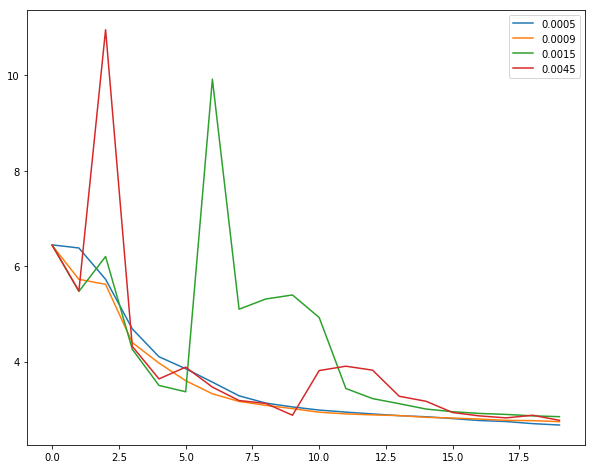

In [21]:
for k, v in results.items():
    plt.plot(v[0], label=k)
plt.legend()

In [25]:
r = train_localizer_network(learning_rate=9e-4)

In [10]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

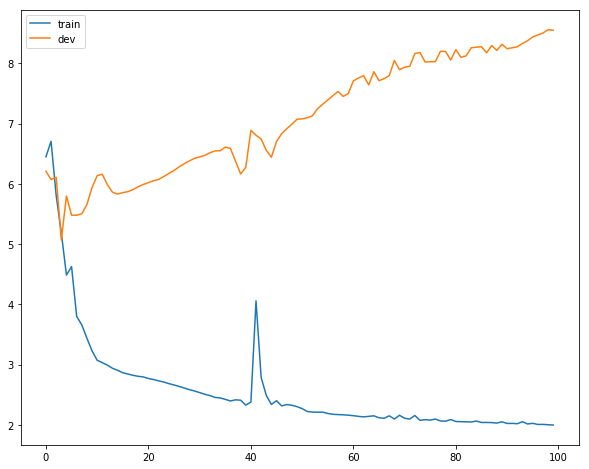

In [15]:
train_losses, dev_losses, train_bleu, dev_bleu = r
plt.plot(train_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()

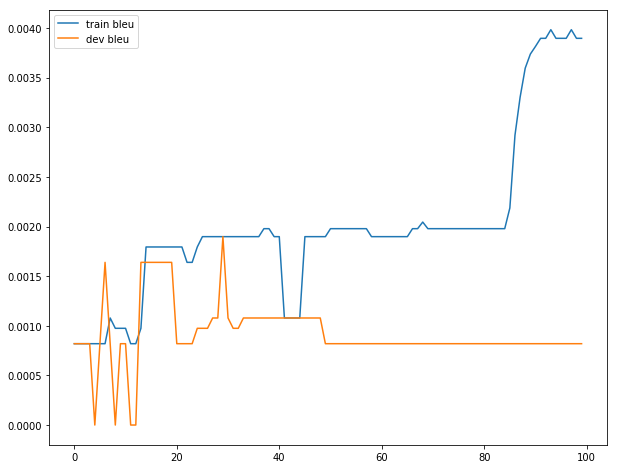

In [16]:
plt.plot(train_bleu, label='train bleu')
plt.plot(dev_bleu, label='dev bleu')
plt.legend()

In [ ]:
def ensure_all_data_is_available():
    import numpy as np
    data_path = '../Data/FullData/train_dev_test.npy'
    ANNOTATION_PATH = '../Data/FullData/Transcriptions/annotations.npy'
    annotations = np.load(ANNOTATION_PATH).item()
    images = (
            np.load(data_path).item()['train'] + np.load(data_path).item()['dev'] + 
            np.load(data_path).item()['test']
    )
    bad = []
    for img in tqdm(images):
        num = img[:img.rfind('_')]
        nut = '1_' + num; ingr = '0_'+num
        if nut not in annotations or ingr not in annotations:
            bad.append(num)
    print(set(bad))